In [1]:
using QuadraticTeamDecisionSolver, Distributions, Statistics, LinearAlgebra, Plots

In [2]:
N= 2;
p = QuadTeamProblem(N, N*N*ones(Int64, N), ones(Int64, N), ComplexF64);

In [3]:
t = teamMMSEproblem(1.5, zeros(Float64, N), ones(Float64, N), zeros(Float64, N), 0.5*ones(Float64, N), 0.2*ones(Float64, N));


In [4]:
m = 15000;
iterations = 15;

In [5]:
Y, R, r = generateTeamMMSEsamples(p, t, m);

In [6]:
w_jacobi = [[rand(ComplexF64, m)] for _ in 1:p.N];
w_alternating = [[rand(ComplexF64, m)] for _ in 1:p.N];

In [7]:
hₒ = ((4*0.5)/(3*m))^(1/5);
conditionalMean(X, Y, y) = densityConditionalMean(exponentialKernel, X, Y, y, hₒ);

In [8]:
empiricalJacobiSolver!(p, w_jacobi, Y, R, r, conditionalMean, iterations = iterations);


In [9]:
empiricalAlternatingSolver!(p, w_alternating, Y, R, r, conditionalMean, iterations = iterations);

In [10]:
conv_jacobi = [norm.(diff(w_jacobi[i])) for i in 1:p.N];
conv_alternating = [norm.(diff(w_alternating[i])) for i in 1:p.N];

In [11]:
testR = reformatR(p.N, m, R);
testr = reformatr(p.N, m, r);
testW_jacobi = reformatW(p.N, m, iterations, w_jacobi);
testW_alternating = reformatW(p.N, m, iterations, w_alternating);

In [12]:
perf_jacobi = [urisk(testW_jacobi[k], testR, testr) for k in 1:iterations];
perf_alternating = [urisk(testW_alternating[k], testR, testr) for k in 1:iterations];

In [15]:
using LaTeXStrings

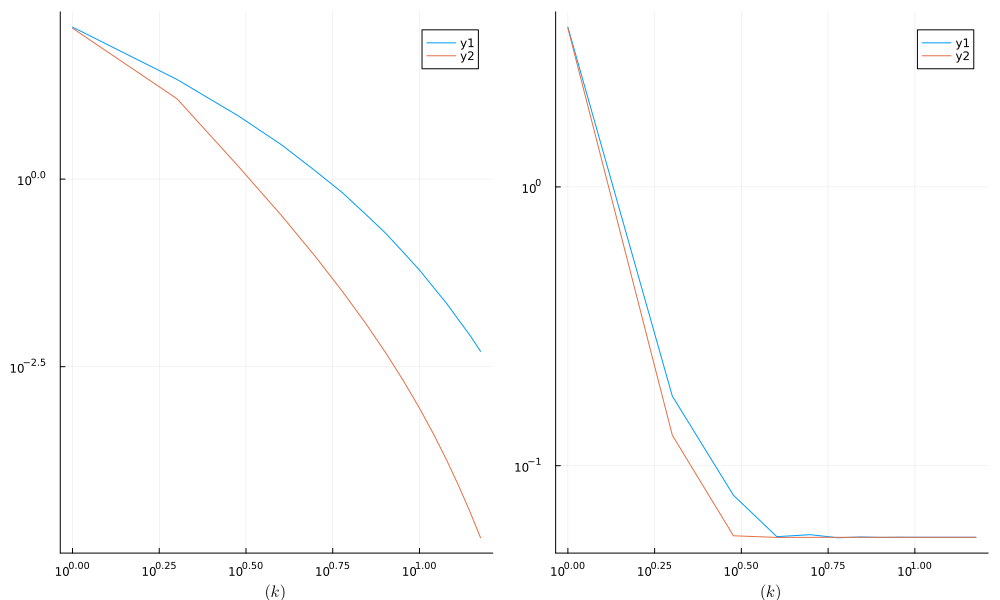

In [19]:
perf = plot([perf_jacobi, perf_alternating], yscale = :log10, xscale = :log10, xlabel = L"(k)");
conv = plot([sum(conv_jacobi) / length(conv_jacobi), sum(conv_alternating) / length(conv_alternating)], yscale = :log10, xscale = :log10, xlabel = L"(k)");
plot(conv, perf, layout = (1, 2), size = (1000, 300))
